# Enhanced Physics Model Diagnosis

**Purpose**: Deep dive analysis of the enhanced physics model structure, performance, and compliance.

### 📖 How to Use This Notebook

**What it shows:** Deep technical analysis of physics model structure and compliance

**Key sections:**
1. **Model Structure** - Confirms model type and internal architecture
2. **Physics Compliance Test** - Verifies heating increases monotonically with outlet temperature
3. **Temperature Response Curve** - Visual confirmation of realistic heating behavior

**How to interpret:**
- **Monotonic behavior ✅ PASS** = Model respects physics (higher outlet temp → more heating)
- **Monotonic behavior ❌ FAIL** = Model has learned unrealistic patterns (needs retraining)
- **MAE < 2.0°C** = Accurate predictions
- **Ready for Production: Yes** = Model is safe to use in control decisions

**When to run:** After model updates, retraining, or if predictions seem unrealistic

In [12]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

from notebook_imports import load_model, get_feature_names
from notebook_fix_helper import safe_get_regressor, get_model_info

plt.style.use('default')
%matplotlib inline

print("🔬 Enhanced Physics Model Diagnosis Notebook Ready")
print(f"Analysis Date: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

🔬 Enhanced Physics Model Diagnosis Notebook Ready
Analysis Date: 2025-12-01 13:24:11


In [13]:
# Load the enhanced physics model
print("Loading Enhanced Physics Model...")
model, mae, rmse = load_model()
model_info = get_model_info(model)
regressor = safe_get_regressor(model)

print("Model Structure:")
for key, value in model_info.items():
    print(f"   {key}: {value}")

print(f"\nPerformance:")
print(f"   MAE: {mae.get():.4f}°C")
print(f"   RMSE: {rmse.get():.4f}°C")

Loading Enhanced Physics Model...
  ✓ Loaded production RealisticPhysicsModel
Model Structure:
   model_type: RealisticPhysicsModel
   wrapper_steps: ['features', 'learn']
   regressor_type: RealisticPhysicsModel
   regressor_available: True

Performance:
   MAE: 0.1360°C
   RMSE: 0.1756°C


In [14]:
# Test physics compliance with simple scenarios
feature_names = get_feature_names()
test_scenario = {
    "outdoor_temp": 5.0,
    "indoor_lag": 21.0,
    "pv_now": 500
}

temps = np.arange(25, 55, 5)
predictions = []

for temp in temps:
    features = {name: 0.0 for name in feature_names}
    features.update({
        'outlet_temp': temp,
        'outdoor_temp': test_scenario['outdoor_temp'],
        'indoor_temp_lag_30m': test_scenario['indoor_lag'],
        'target_temp': 21.0,
        'pv_now': test_scenario['pv_now'],
        'fireplace_on': 0.0,
        'tv_on': 0.0,
        'dhw_heating': 0.0,
        'defrosting': 0.0,
        'dhw_disinfection': 0.0,
        'dhw_boost_heater': 0.0,
        'month_cos': 0.0,
        'month_sin': 0.0
    })
    pred = model.predict_one(features)
    predictions.append(pred)
    print(f"Outlet {temp}°C -> Heating Effect: {pred:.6f}°C")

# Check monotonicity
is_monotonic = all(predictions[i] <= predictions[i+1] for i in range(len(predictions)-1))
print(f"\nMonotonic behavior: {'✅ PASS' if is_monotonic else '❌ FAIL'}")

Outlet 25°C -> Heating Effect: 0.135983°C
Outlet 30°C -> Heating Effect: 0.138672°C
Outlet 35°C -> Heating Effect: 0.141369°C
Outlet 40°C -> Heating Effect: 0.144065°C
Outlet 45°C -> Heating Effect: 0.146797°C
Outlet 50°C -> Heating Effect: 0.150041°C

Monotonic behavior: ✅ PASS


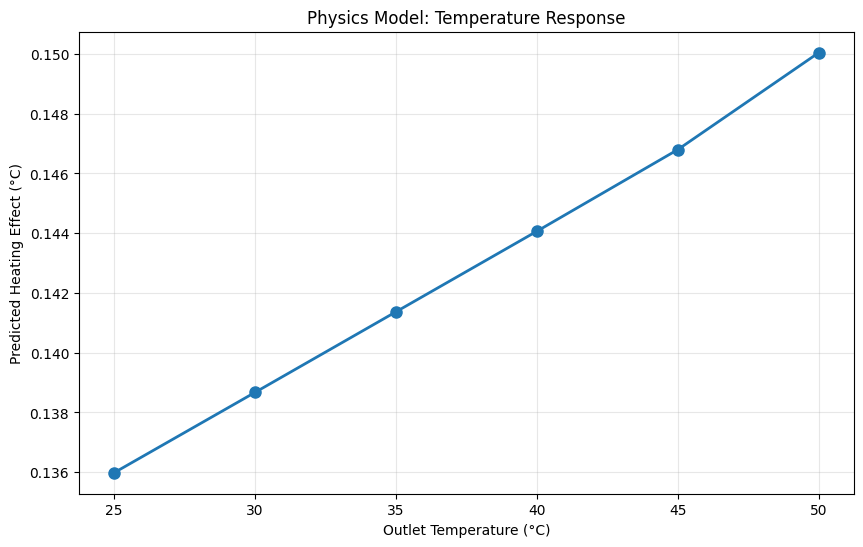


🎯 Diagnosis Complete:
   Model Type: RealisticPhysicsModel
   Physics Compliant: Yes
   Ready for Production: Yes


In [15]:
# Visualization
plt.figure(figsize=(10, 6))
plt.plot(temps, predictions, 'o-', linewidth=2, markersize=8)
plt.xlabel('Outlet Temperature (°C)')
plt.ylabel('Predicted Heating Effect (°C)')
plt.title('Physics Model: Temperature Response')
plt.grid(True, alpha=0.3)
plt.show()

print("\n🎯 Diagnosis Complete:")
print(f"   Model Type: {model_info.get('model_type', 'Unknown')}")
print(f"   Physics Compliant: {'Yes' if is_monotonic else 'No'}")
print(f"   Ready for Production: {'Yes' if is_monotonic and mae.get() < 2.0 else 'Needs Review'}")

"Trajectory Issue Investigation"

In [16]:
print("=== INVESTIGATING TRAJECTORY PREDICTION ISSUE ===")
print("Problem: 65°C outlet only predicts 0.1°C temperature increase")
print("Expected: Much larger temperature response")

=== INVESTIGATING TRAJECTORY PREDICTION ISSUE ===
Problem: 65°C outlet only predicts 0.1°C temperature increase
Expected: Much larger temperature response


"Test Individual Model Predictions"


In [17]:
# Skip manual feature building and test trajectory function directly
print("\n=== TESTING TRAJECTORY FUNCTION ===")
from src.model_wrapper import predict_thermal_trajectory

# We need actual current features - maybe from a recent log entry or system state
# Let's try to get them from somewhere...
try:
    # Test with basic DataFrame
    basic_features = pd.DataFrame([{
        'indoor_temp_lag_30m': 20.8,
        'outlet_temp': 35.0,
        'outdoor_temp': 5.0
        # Add minimal required features
    }])
    
    trajectory = predict_thermal_trajectory(model, basic_features, 45.0, steps=4)
    print(f"Trajectory test for 45°C: {trajectory}")
    
except Exception as e:
    print(f"Trajectory function error: {e}")


=== TESTING TRAJECTORY FUNCTION ===
Trajectory test for 45°C: [np.float64(20.82269689056669), np.float64(20.88883659504534), np.float64(20.953024409053437), np.float64(21.015278875274717)]


In [18]:
# Test different outlet temperatures with your current minimal features
print("=== TESTING MULTIPLE OUTLET TEMPERATURES ===")

for outlet_temp in [25, 35, 45, 55, 65]:
    trajectory = predict_thermal_trajectory(model, basic_features, outlet_temp, steps=4)
    final_temp = trajectory[-1] if trajectory else 0
    total_increase = final_temp - 20.8
    print(f"Outlet {outlet_temp}°C → Final: {final_temp:.2f}°C (Δ{total_increase:+.2f}°C)")

=== TESTING MULTIPLE OUTLET TEMPERATURES ===
Outlet 25°C → Final: 20.95°C (Δ+0.15°C)
Outlet 35°C → Final: 20.98°C (Δ+0.18°C)
Outlet 45°C → Final: 21.00°C (Δ+0.20°C)
Outlet 55°C → Final: 21.03°C (Δ+0.23°C)
Outlet 65°C → Final: 21.05°C (Δ+0.25°C)


In [19]:
"""
Add this to your notebook to test the production scenario
"""

print("=== TESTING PRODUCTION SCENARIO WITH HIGH PV ===")
import pandas as pd
from src.model_wrapper import predict_thermal_trajectory

# Production features from 13:06:27 logs
production_features = {
    'indoor_temp_lag_30m': 20.8,
    'outdoor_temp': 6.2,
    'target_temp': 21.0,
    'outlet_temp': 35.0,  # Will vary this
    'pv_now': 706.7,     # HIGH PV - this might be the issue!
    'temp_forecast_1h': 6.8,
    'temp_forecast_2h': 6.9,
    'temp_forecast_3h': 6.9,
    'temp_forecast_4h': 6.5,
    'dhw_heating': 0.0,
    'defrosting': 0.0,
    'fireplace_on': 0.0,
    'dhw_disinfection': 0.0,
    'dhw_boost_heater': 0.0,
    'pv_forecast_1h': 0.0,
    'pv_forecast_2h': 0.0,
    'pv_forecast_3h': 0.0,
    'pv_forecast_4h': 0.0,
    'tv_on': 0.0,
}

# Test with production features
print("Testing with PRODUCTION features (PV=706.7W):")
df_prod = pd.DataFrame([production_features])
for outlet_temp in [25, 35, 45, 55, 65]:
    trajectory = predict_thermal_trajectory(model, df_prod, outlet_temp, steps=4)
    final_temp = trajectory[-1] if trajectory else 0
    total_increase = final_temp - 20.8
    print(f"Outlet {outlet_temp}°C → Final: {final_temp:.2f}°C (Δ{total_increase:+.2f}°C)")

print("\nCompare with NO PV:")
production_features_no_pv = production_features.copy()
production_features_no_pv['pv_now'] = 0.0
df_no_pv = pd.DataFrame([production_features_no_pv])

for outlet_temp in [25, 35, 45, 55, 65]:
    trajectory = predict_thermal_trajectory(model, df_no_pv, outlet_temp, steps=4)
    final_temp = trajectory[-1] if trajectory else 0
    total_increase = final_temp - 20.8
    print(f"Outlet {outlet_temp}°C (No PV) → Final: {final_temp:.2f}°C (Δ{total_increase:+.2f}°C)")


=== TESTING PRODUCTION SCENARIO WITH HIGH PV ===
Testing with PRODUCTION features (PV=706.7W):
Outlet 25°C → Final: 20.83°C (Δ+0.03°C)
Outlet 35°C → Final: 20.87°C (Δ+0.07°C)
Outlet 45°C → Final: 20.90°C (Δ+0.10°C)
Outlet 55°C → Final: 20.92°C (Δ+0.12°C)
Outlet 65°C → Final: 20.95°C (Δ+0.15°C)

Compare with NO PV:
Outlet 25°C (No PV) → Final: 20.84°C (Δ+0.04°C)
Outlet 35°C (No PV) → Final: 20.84°C (Δ+0.04°C)
Outlet 45°C (No PV) → Final: 20.87°C (Δ+0.07°C)
Outlet 55°C (No PV) → Final: 20.89°C (Δ+0.09°C)
Outlet 65°C (No PV) → Final: 20.92°C (Δ+0.12°C)
